<a href="https://colab.research.google.com/github/Jorgecuenca1/Vision-computadora-I/blob/main/TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo Practico Nº3 - Vision Por Computadora I**
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. Obtener una detección del logo en cada imagen sin falsos positivos.

In [431]:
#importa librerias
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir

In [432]:
def cargar_imagenes():
    # Me posiciono en el directorio con las imagenes
    os.chdir("./content")
    # Lo guardo en una variable
    folder_dir = os.getcwd()
    # Vuelvo al directorio principal
    os.chdir("..")
    # Creo la variable en donde se guardaran las imagenes
    img_obj = []
    patron = None
    img_multiple = None

    # Recorro el directorio para cargar las imagenes
    for images in os.listdir(folder_dir):
        # Verifico que la imagen termine en .png o .jpg
        if (images.endswith(".png") or images.endswith(".jpg")):
            path = os.path.join(folder_dir, images)
            img = cv.imread(path)
            # Si la imagen es el patron la guardo en la variable correspondiente
            if ('pattern' in images):
                patron = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            # Si la imagen es el multiple la guardo en la variable correspondiente
            elif ('coca_multi' in images):
                img_multiple = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            # Sino cumple ninguna de las condiciones anteriores la guardo en el arreglo
            else:
                img_obj.append(cv.cvtColor(img, cv.COLOR_BGR2RGB))

    return (img_obj, img_multiple, patron)

def graficar_imagenes( img_obj, img_multiple, patron ):
    # Recorro y grafico las imagenes obteivo
    plt.figure()
    plt.suptitle("Imagenes objetivos")
    for i in range(len(img_obj)):
        plt.subplot(2, 3, (i+1))
        plt.imshow(img_obj[i])
    plt.show()

    # Grafico el patron a encontrar
    plt.title("Imagen multiple")
    plt.imshow(img_multiple)
    plt.show()

    # Grafico el patron a encontrar
    plt.title("Imagen patron")
    plt.imshow(patron)
    plt.show()

    return

def imagenes_gray(img_obj, img_multiple, patron):
    # Convertivos a escalas de grises y procesamos las imagenes objetivos
    img_gray = []
    for i  in range(len(img_obj)):
        gray = cv.cvtColor(img_obj[i], cv.COLOR_RGB2GRAY)
        img_gray.append(gray)

     # Convertimos el patron en escala de grises
    img_multiple_gray = cv.cvtColor(img_multiple, cv.COLOR_BGR2GRAY)

    # Convertimos el patron en escala de grises
    patron_gray = cv.cvtColor(patron, cv.COLOR_BGR2GRAY)

    return (img_gray, img_multiple_gray, patron_gray)

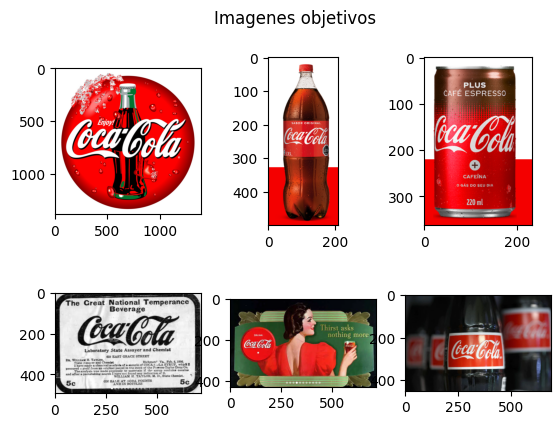

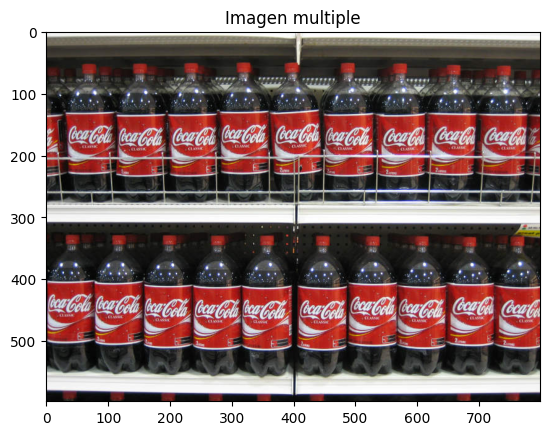

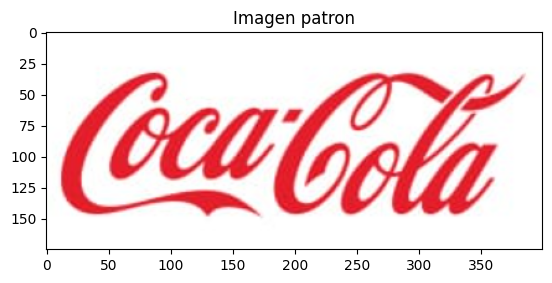

In [433]:
img_obj, img_multiple, patron = cargar_imagenes()
graficar_imagenes( img_obj, img_multiple, patron )
img_gray, img_multiple_gray, patron_gray = imagenes_gray(img_obj, img_multiple, patron)

In [434]:
def SIFT_detector( patron, img_gray ):

    # Inicio el detector SIFT
    sift = cv.xfeatures2d.SIFT_create()
    # Encuentro keypoints y descriptors con SIFT
    kp1, des1 = sift.detectAndCompute(patron,None)
    kp2, des2 = sift.detectAndCompute(img_gray,None)
    # Parámetros FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    # Encontro la coincidencia más cercana con el algoritmo KNN
    matches = flann.knnMatch(des1,des2,k=2)
    # inicializo la lista para guardar solo los puntos buenos de las coincidencias
    good = []
    # Para todas las coincidencias calculo las distancias y me quedo con los puntos que cumplen la condicion 
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return (kp1, kp2, good)

def homography_find( kp1, kp2, patron, good ):

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    # Encuentro la transformación de perspectiva entre los dos planos
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    # Dimensiones de la imagen patron a buscar
    h,w = patron.shape
    # Guardo todos los puntos en pts
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    # Aplico el algoritmo de perspectiva
    dst = cv.perspectiveTransform(pts,M)
    return dst

def matching( imagen_rgb, imagen_gray, patron_gray ):

    # Minima cantida de puntos a encontrar para que se acepte como buena la busqueda
    MIN_MATCH_COUNT = 10

    # Patron en escala de grises invertido
    th, im_th = cv.threshold(patron_gray, 200, 255, cv.THRESH_BINARY_INV)
    patron = cv.GaussianBlur(im_th, (5,5), 0)
    # Patron en escalas de grises sin invertir
    patron2 = patron_gray

    # Para cada una de las imagenes calculo el 
    for i  in range(len(imagen_gray)):

        # Imagen en rgb y escalas de grises en donde busco el patron
        img_rgb  = imagen_rgb[i].copy()
        img_gray = imagen_gray[i]
        kp1, kp2, good = SIFT_detector(patron, img_gray)
        # Si cumplo con la cantidad de buenos puntos encontrados (good) realizo la homografia y marco el resultado en la imagen 
        if len(good)>MIN_MATCH_COUNT:
            dst = homography_find( kp1, kp2, patron, good)
            img_rgb = cv.polylines(img_rgb,[np.int32(dst)],True,(0,0,255),3, cv.LINE_AA)
        #Si no cumplo con la cantidad de puntos vuelvo a ejecutar el algortimo pero con el patron sin invertir 
        else:
            kp1, kp2, good  = SIFT_detector(patron2, img_gray)
            if len(good)>MIN_MATCH_COUNT:
                dst = homography_find( kp1, kp2, patron, good)
                img_rgb = cv.polylines(img_rgb,[np.int32(dst)],True,(0,0,255),3, cv.LINE_AA)
            else:
                #Si no cumplo con la cantidad de puntos nuevamente imprimo el siguiente mensaje
                print( "No se encuentran suficientes coincidencias - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        # Grafico el resultado
        plt.imshow(img_rgb)
        plt.show()

    return

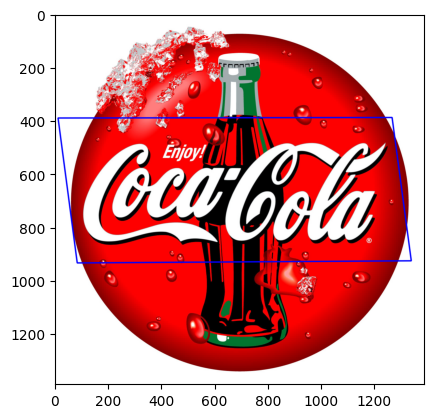

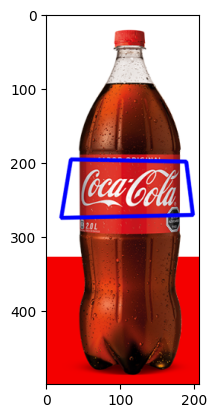

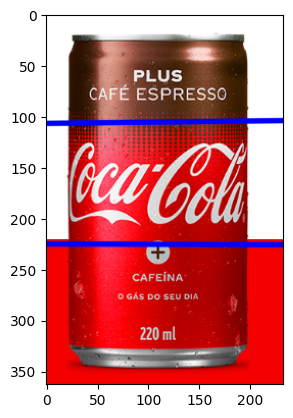

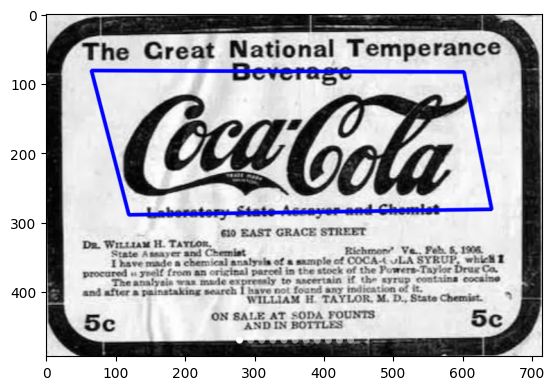

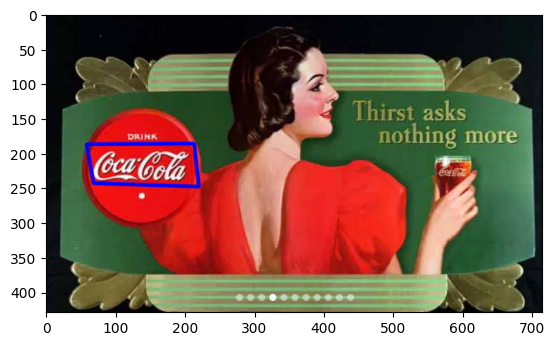

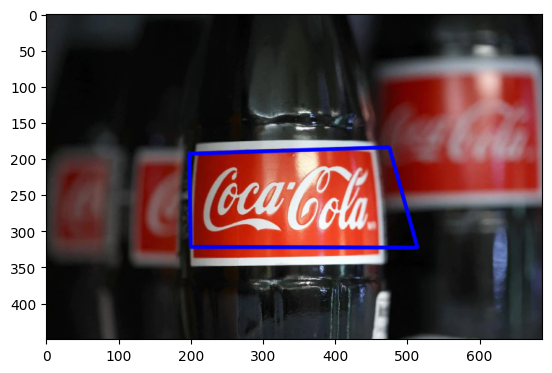

In [435]:
#Ejecuto la funcion para obtener la deteccion del logo en las imagenes
matching( img_obj, img_gray, patron_gray )

## Conclusión

#### En el codigo recorro las imagenes objetivos con el patron que esta en diferentes escalas y procesado (GaussianBlur y adaptiveThreshold) para mejorarlo antes de aplicar el algoritmo de features matching. Finalmentese se grafican los resultados de cada imagen objetivo con el border box hallado.

2. Plantear y validaar un algoritmo para multiples detecciones en la imagen multi.png

In [436]:
def matching_multiple(img_multiple, img_gray_mult, patron_gray):

    #Guardo la imagen para mostrar los resultados
    res_multiple = img_multiple.copy()

    # Procesamos la imagen para obtener los bordes
    img_gray_canny = cv.Canny(img_gray_mult, 150, 250)

    # Variables para guardar la mejor iteracion
    mejor_val_max = None
    mejor_loc = None
    mejor_res = None

    #Bucle para variar el tamaño de la escala
    for scale in np.linspace(0.2, 5.0, 50)[::-1]:
        # Reducimos y ampliamos la imagen patron para recorrer los posibles tamaños que el patron pueda tener en la imagen objetivo
        patron_resized = cv.resize(patron_gray, (int(patron_gray.shape[1]*scale), int(patron_gray.shape[0]*scale)))
        # Verificamos que las dimensiones de la imagen objetivo sean mayor que la del patron 
        if( (img_gray_mult.shape[0] > patron_resized.shape[0]) and (img_gray_mult.shape[1] > patron_resized.shape[1]) ):
            # Procesamos el patron redimencionado
            patron_gauss = cv.GaussianBlur(patron_resized, (5,5), 0)
            patron_canny = cv.Canny(patron_gauss, 50, 200)
            
            # Aplicamos la coincidencia de patrones
            res = cv.matchTemplate(img_gray_canny, patron_canny, cv.TM_CCORR_NORMED)
        
            # Encontramos los valores máximos y mínimos
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

            # Si el valor maximo encontrado anteriormente es mayor al que teniamos guardado reemplazamos los valores por los de la corrida actual
            if ( mejor_val_max is None or (max_val > mejor_val_max) ):
                mejor_val_max = max_val
                mejor_res = res
                h, w = patron_resized.shape[::]

    # Tomo un porcentaje del valor maximo resultante del algoritmo para quedarme solo con los puntos que cumplan ser mayor a eso   
    threshold = mejor_val_max*0.921
    loc = np.where( mejor_res >= threshold )
    #-1 para intercambiar los valores a medida que asignamos las coordenadas x e y para dibujar el rectángulo
    for pt in zip(*loc[::-1]):   
        # Dibujo un rectángulo alrededor de cada objeto. Conocemos la parte superior izquierda (pt), dibujo un rectángulo para que coincida con el tamaño de la imagen de la plantilla
        cv.rectangle(res_multiple, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 4)  

    # Graficamos el procesamiento y la salida
    plt.subplots(1, 2, figsize=(20,20))

    # Resultado de coincidencia
    plt.subplot(1,2,1)
    plt.imshow(mejor_res,cmap = 'gray')
    plt.title('Matching Resultado')
        
    # Imagen original con recuadros
    plt.subplot(1,2,2)
    plt.imshow(res_multiple)
    plt.title('Puntos detectados')

    plt.show()

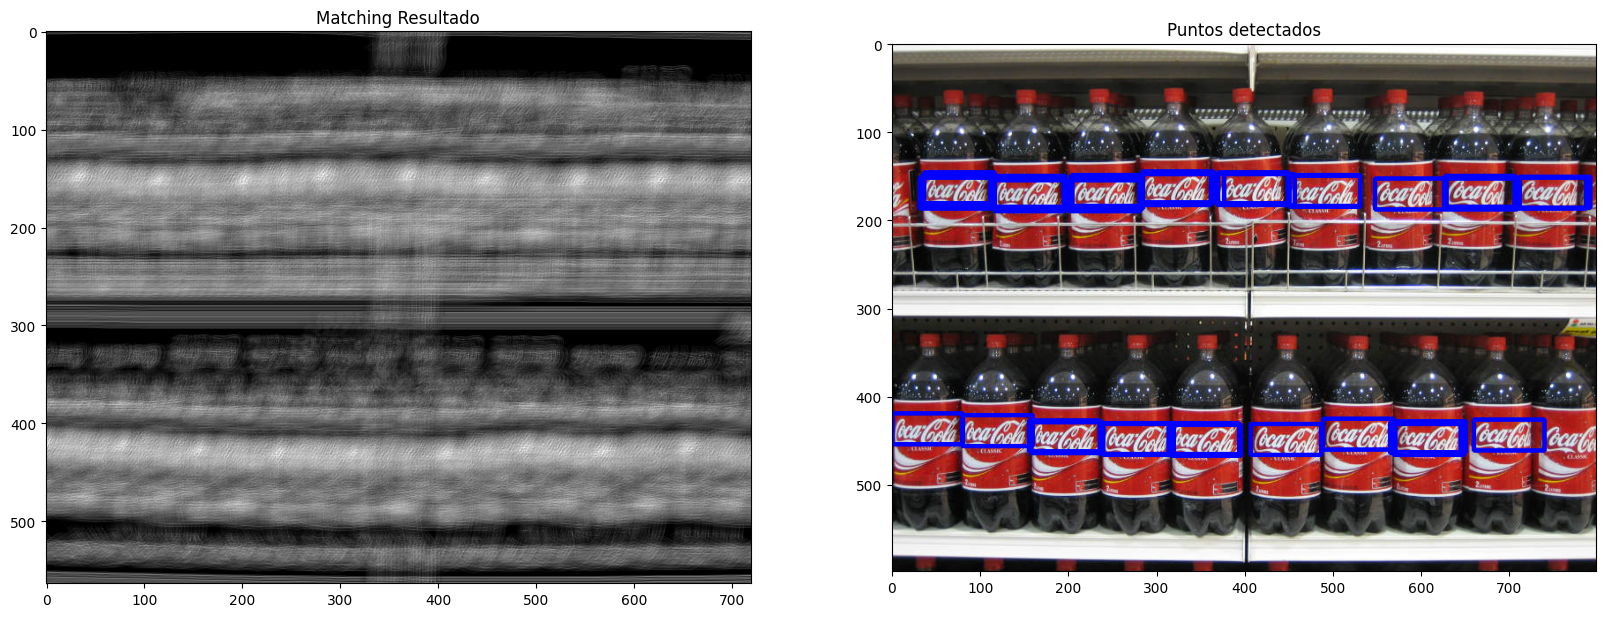

In [437]:
matching_multiple(img_multiple, img_multiple_gray, patron_gray)

## Conclusión

#### Este codigo a diferencia del anterior sirver para encontrar en una misma imagen varias veces el mismo patron. Se toma el valor max de la mejor corrida modificandole la escala y luego se le aplica un porcentaje para que de esta manera abarque los diferentes lugares en donde hay posibilidades que este dicho patron. Finalmente se muestran los resultados obtenidos.

3. Generalizar el algoritmo del item 2 para todas las imagenes

In [438]:
def SIFT_detector(patron, img_gray):

    # Inicio el detector SIFT
    sift = cv.xfeatures2d.SIFT_create()
    # Encuentro keypoints y descriptors con SIFT
    kp1, des1 = sift.detectAndCompute(patron,None)
    kp2, des2 = sift.detectAndCompute(img_gray,None)
    # Parámetros FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    # Encontro la coincidencia más cercana con el algoritmo KNN
    matches = flann.knnMatch(des1,des2,k=2)
    # inicializo la lista para guardar solo los puntos buenos de las coincidencias
    good = []
    # Para todas las coincidencias calculo las distancias y me quedo con los puntos que cumplen la condicion 
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return (kp1, kp2, good)

def homography_find( kp1, kp2, patron, good):

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    # Encuentro la transformación de perspectiva entre los dos planos
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    # Dimensiones de la imagen patron a buscar
    h,w = patron.shape
    # Guardo todos los puntos en pts
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    # Aplico el algoritmo de perspectiva
    dst = cv.perspectiveTransform(pts,M)
    return dst

def matching( imagen_rgb, imagen_gray, patron_gray ):

    # Minima cantida de puntos a encontrar para que se acepte como buena la busqueda
    MIN_MATCH_COUNT = 10

    # Patron en escala de grises invertido
    th, im_th = cv.threshold(patron_gray, 200, 255, cv.THRESH_BINARY_INV)
    patron = cv.GaussianBlur(im_th, (5,5), 0)
    # Patron en escalas de grises sin invertir
    patron2 = patron_gray

    # Para cada una de las imagenes calculo el 
    for i  in range(len(imagen_gray)):

        # Imagen en rgb y escalas de grises en donde busco el patron
        img_rgb  = imagen_rgb[i].copy()
        img_gray = imagen_gray[i]
        kp1, kp2, good = SIFT_detector(patron, img_gray)
        # Si cumplo con la cantidad de buenos puntos encontrados (good) realizo la homografia y marco el resultado en la imagen 
        if len(good)>MIN_MATCH_COUNT:
            dst = homography_find( kp1, kp2, patron, good)
            img_rgb = cv.polylines(img_rgb,[np.int32(dst)],True,(0,0,255),3, cv.LINE_AA)
        #Si no cumplo con la cantidad de puntos vuelvo a ejecutar el algortimo pero con el patron sin invertir 
        else:
            kp1, kp2, good  = SIFT_detector(patron2, img_gray)
            if len(good)>MIN_MATCH_COUNT:
                dst = homography_find( kp1, kp2, patron, good)
                img_rgb = cv.polylines(img_rgb,[np.int32(dst)],True,(0,0,255),3, cv.LINE_AA)
            else:
                matching_multiple(img_rgb, img_gray, patron2)
                break
        # Grafico el resultado
        plt.imshow(img_rgb)
        plt.show()
    return

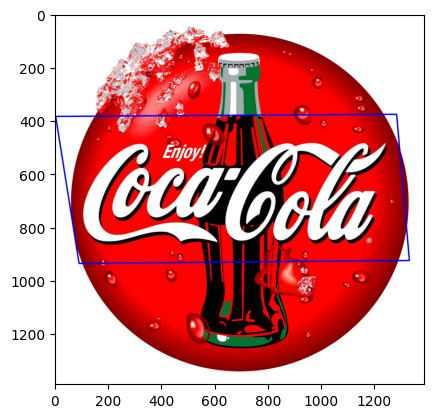

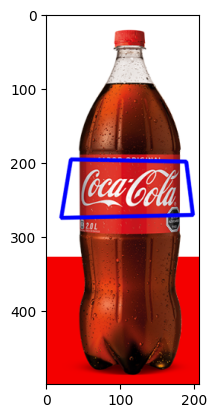

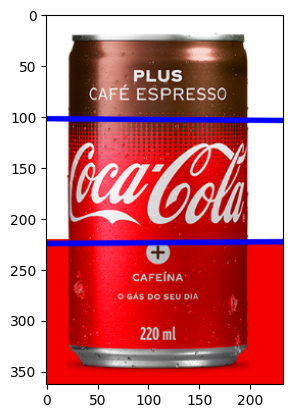

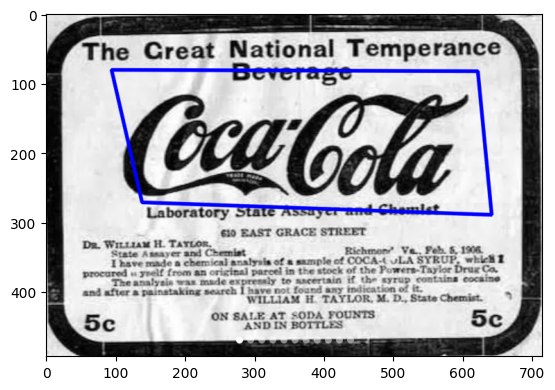

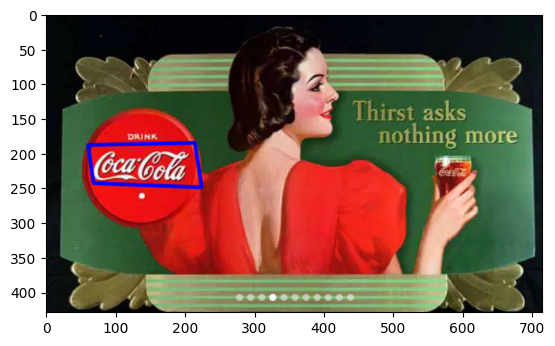

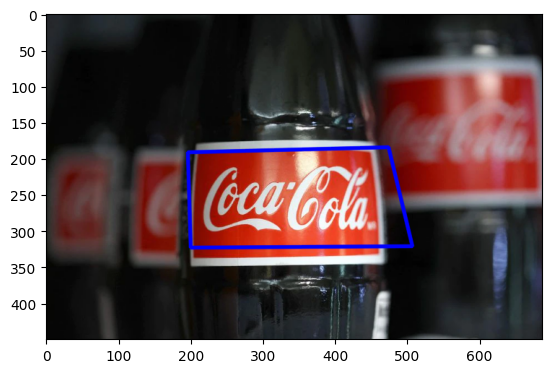

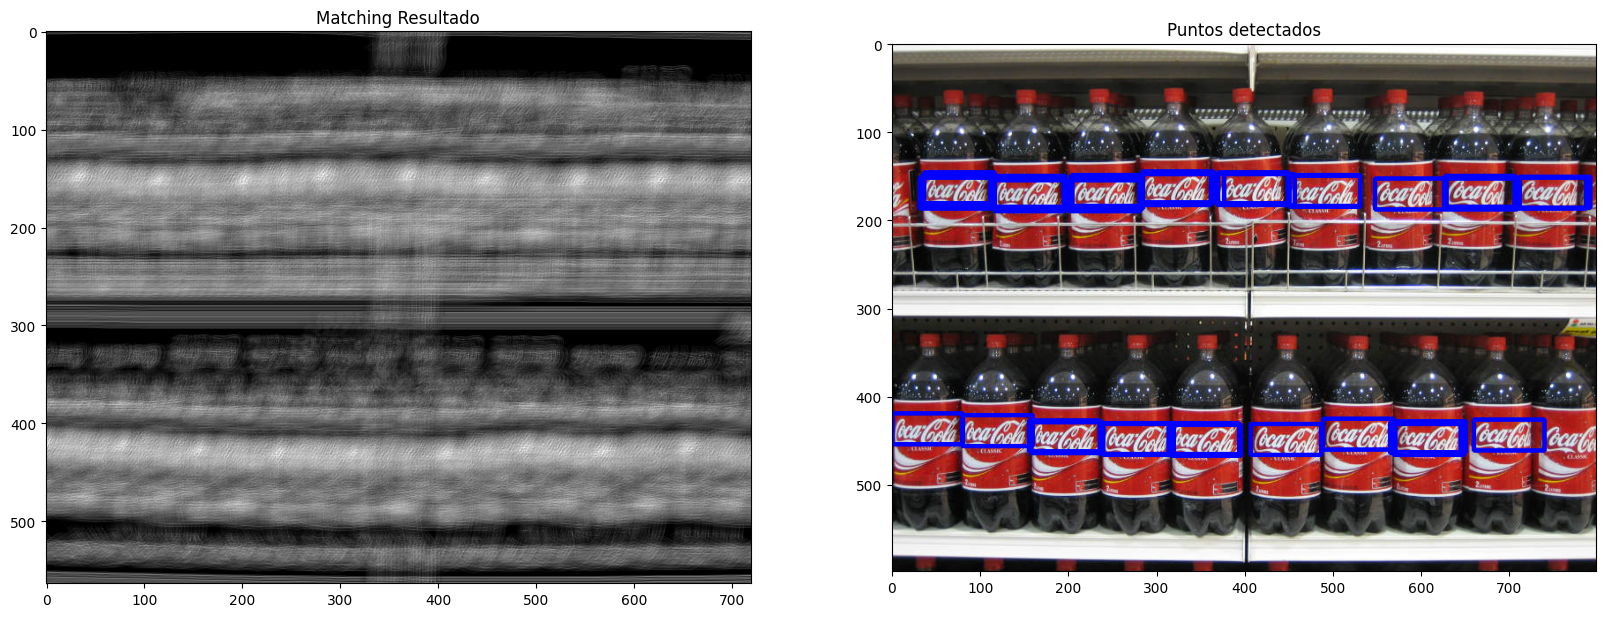

In [439]:
# Agrego la imagen multiple a la lista de imagenes objetivo
img_obj.append(img_multiple)
# Agrego la imagen multiple en escala de grises a la lista de imagenes objetivo en escala de grises
img_gray.append(img_multiple_gray)
# Ejecuto el algoritmo para todas las imagenes 
matching(img_obj, img_gray, patron_gray)